In [1]:
using Random
using LinearAlgebra: I
using Distributions
using Plots

In [2]:
"""
Hyperparameters for the object-aware HDP+,infinity generative model.

m0      : prior mean for feature vectors (d-dimensional)
k_clu   : shrinkage from cluster means mu_k toward m0
k_obj   : shrinkage from object means phi_i toward their cluster mean mu_k
k_per   : shrinkage from percepts y_io toward their object mean phi_i
a0,b0   : Inverse-Gamma hyperparameters for sigma^2 (per category)
"""
Base.@kwdef struct ObjectAwareHDPHyperparams
    m0::Vector{Float64}
    k_clu::Float64
    k_obj::Float64
    k_per::Float64
    a0::Float64
    b0::Float64
end

"Data for one object: its category label, cluster label, and percepts."
Base.@kwdef struct ObjectData
    j::Int                              # category index
    z::Int                              # cluster index
    phi::Vector{Float64}                # object mean (latent)
    percepts::Vector{Vector{Float64}}   # y_o \in R^d for o = 1..O_i
end

"All data for one cluster in a category."
Base.@kwdef struct ClusterSample
    j::Int                              # category index
    k::Int                              # cluster index
    mu::Vector{Float64}                 # cluster mean
    objects::Vector{ObjectData}         # all objects assigned to this cluster
end

"All data for a single category."
Base.@kwdef struct CategorySample
    j::Int                              # category index
    sigma2::Float64                     # category variance
    mus::Vector{Vector{Float64}}        # cluster means mu_k
    objects::Vector{ObjectData}         # objects i = 1..I
end

"Full dataset across multiple categories."
Base.@kwdef struct Dataset
    categories::Vector{CategorySample}  # length J
end

Dataset

In [3]:
"""
    sample_crp_cluster!(n_k, alpha, rng)

Given current cluster counts n_k (length K), sample a cluster index k for a new object
using a CRP(alpha). If k == K+1, this means "start a new cluster".
"""
function sample_crp_cluster!(; n_k::Vector{Int}, alpha::Float64, rng=Random.default_rng())
    K = length(n_k)
    if K == 0
        push!(n_k, 1)
        return 1
    end 
    total = sum(n_k) + alpha
    weights = K == 0 ? [1.0] : [n / total for n in n_k]  # existing clusters
    push!(weights, alpha / total)                        # new cluster option
    k = rand(rng, Categorical(weights))
    if k == K + 1
        push!(n_k, 0)  # initialize count for new cluster
    end
    n_k[k] += 1
    return k
end


sample_crp_cluster!

In [4]:
"""
    sample_category(Ii, O, d, alpha, hyper, rng=Random.default_rng())

Sample one category under the object-aware HDP+,infinity generative model.

Arguments
--------
j     : category label
Ii    : number of objects in the category (adding i to avoid confusion with LinearAlgebra.I)
O     : number of percepts per object (fixed for simplicity)
d     : feature dimension
alpha : CRP concentration (controls number of clusters)
hyper : ObjectAwareHDPHyperparams

Returns
-------
CategorySample with sigma^2, cluster means mu_k, and per-object percept data.
"""
function sample_category(; j::Int, Ii::Int, O::Int, d::Int,
                         alpha::Float64,
                         hyper::ObjectAwareHDPHyperparams,
                         rng = Random.default_rng())

    # 1. Category-specific variance
    sigma2 = rand(rng, InverseGamma(hyper.a0, hyper.b0))

    # 2. Storage for cluster means and counts
    mus = Vector{Vector{Float64}}()  # mu_k
    n_k = Int[]                      # counts per cluster

    # 3. Sample objects
    objects = Vector{ObjectData}(undef, Ii)

    for i in 1:Ii
        # 3a. CRP: choose cluster for object i
        k = sample_crp_cluster!(n_k=n_k, alpha=alpha, rng=rng)

        # If this is a brand-new cluster, sample its mean mu_k
        if k > length(mus)
            sigma_clu = (sigma2 / hyper.k_clu) * I(d)
            mu_k = rand(rng, MvNormal(hyper.m0, sigma_clu))
            push!(mus, mu_k)
        end
        mu_k = mus[k]

        # 3b. Sample object-level mean phi_i given mu_k
        sigma_obj = (sigma2 / hyper.k_obj) * I(d)
        phi_i = rand(rng, MvNormal(mu_k, sigma_obj))

        # 3c. Sample percepts for this object
        sigma_per = (sigma2 / hyper.k_per) * I(d)
        ys_i = Vector{Vector{Float64}}(undef, O)
        for o in 1:O
            ys_i[o] = rand(rng, MvNormal(phi_i, sigma_per))
        end

        objects[i] = ObjectData(j, k, phi_i, ys_i)
    end

    return CategorySample(j, sigma2, mus, objects)
end


sample_category

In [5]:
"""
    build_clusters(cat::CategorySample) -> Vector{ClusterSample}

Reconstruct cluster-level data for a sampled category.

Given a `CategorySample`, this function groups all `ObjectData` objects
according to their cluster labels (`obj.z`) and returns a vector of
`ClusterSample` structs. Each `ClusterSample` contains:

  • the category index `j`
  • the cluster index `k`
  • the cluster mean `mu_k`
  • all objects assigned to that cluster

The resulting vector is sorted by the cluster index `k` (ascending).

Parameters
----------
cat :: CategorySample
    Output of `sample_category` containing category-level variance, cluster
    means, and object-level assignments.

Returns
-------
Vector{ClusterSample}
    One entry per cluster present in the category.
"""
function build_clusters(cat::CategorySample)
    # group objects by cluster index z
    groups = Dict{Int, Vector{ObjectData}}()
    for obj in cat.objects
        push!(get!(groups, obj.z, ObjectData[]), obj)
    end

    clusters = ClusterSample[]
    for (k, objs) in sort(collect(groups); by = first)  # ensure ordered by k
        mu_k = cat.mus[k]
        push!(clusters, ClusterSample(j = cat.j, k = k, mu = mu_k, objects = objs))
    end

    return clusters
end


build_clusters

Pseudocode for constructing training/test set

Within each category, 

10 objects & 50 percepts in training
- Skewed: [18, 9, 6, 5, 4, 3, 2, 2, 1]
- Uniform: 5 percepts/objects 

10 objects & 50 percepts in test
- 5 percepts/objects

Use sample_category() to sample 10 objects, each with 18 percepts / category
Construct the sets s.t.
- Each object gets to be the most dominant one
- Each object appears in both training and test
- If an object is not the most dominant one in training / is part of test set, randomly sample the number of percepts needed

Get permutation of object ids 1-20. The first 10 becomes training (with frequency in this order) and the last 10 becomes test.

In [58]:
# Dimension & hyperparameters
D = 2
ALPHA = 1.0
Ii = 10         # objects per category
O = 18          # percepts per object

hyper1 = ObjectAwareHDPHyperparams(
    m0     = [-5.0, -5.0], #zeros(D),
    k_clu  = 1.0,
    k_obj  = 2.0,
    k_per  = 20.0,
    a0     = 2.0,
    b0     = 2.0
)
category1 = sample_category(j=1, Ii=Ii, O=O, d=D, alpha=ALPHA, hyper=hyper1, rng=MersenneTwister(42));

hyper2 = ObjectAwareHDPHyperparams(
    m0     = [5.0, 5.0], #zeros(D),
    k_clu  = 1.0,
    k_obj  = 2.0,
    k_per  = 20.0,
    a0     = 2.0,
    b0     = 2.0
)
category2 = sample_category(j=2, Ii=Ii, O=O, d=D, alpha=ALPHA, hyper=hyper2, rng=MersenneTwister(7));

In [73]:
"""
    plot_category_2d(cat::CategorySample, hyper::ObjectAwareHDPHyperparams;
                     r_scale::Float64 = 1.0)

Visualize a single `CategorySample` in 2D assuming `d = 2`.

For the given category:
  * Plot the global/category prior mean `m0`.
  * For each cluster, plot its mean `mu_k` and draw a line from `m0` to `mu_k`.
  * For each object:
      - Plot its mean `phi_i`.
      - Draw a circle around `phi_i` with radius proportional to the
        percept-level standard deviation: r = r_scale * sqrt(sigma^2 / k_per).
      - Draw a line from `mu_k` to `phi_i`.
      - Plot each percept `y_io` as a small marker.

Arguments
---------
cat    :: CategorySample
    Category to visualize (must be 2D: length of `mu` and `phi` is 2).
hyper  :: ObjectAwareHDPHyperparams
    Hyperparameters, providing `m0` and `k_per`.
r_scale :: Float64
    Optional scaling factor for the percept circles (default 1.0).

Returns
-------
plt :: Plots.Plot
    The generated plot object.
"""
function plot_category(cat::CategorySample,
                       hyper::ObjectAwareHDPHyperparams;
                       r_scale::Float64 = 2.0)

    # sanity check
    @assert length(hyper.m0) == 2 "plot_category_2d assumes 2D m0"
    @assert all(length(mu) == 2 for mu in cat.mus) "All cluster means must be 2D"

    # base plot
    plt = plot(
        legend = true,
        aspect_ratio = :equal,
        xlabel = "x1",
        ylabel = "x2",
        title = "Category $(cat.j)"
    )

    # 1. Plot m0 (prior mean) as a star
    m0x, m0y = hyper.m0[1], hyper.m0[2]
    scatter!(plt, [m0x], [m0y],
             marker = :star5, ms = 10,
             color = :red,
             label = "m0 (prior mean)")

    # radius for percept circles: std dev at percept level
    r_per = r_scale * sqrt(cat.sigma2 / hyper.k_per)

    # 2. Loop over clusters
    K = length(cat.mus)
    cluster_colors = distinguishable_colors(K)

    for (k, mu_k) in enumerate(cat.mus)
        mux, muy = mu_k[1], mu_k[2]
        color = cluster_colors[k]

        # connect mu_k to m0
        plot!(plt, [m0x, mux], [m0y, muy],
              lc = :gray, alpha = 0.7, label=false)

        # plot mu_k itself
        scatter!(plt, [mux], [muy], c = color,
                 marker = :diamond, ms = 8,
                 label = k == 1 ? "mu_k (cluster means)" : "")

        # collect objects belonging to this cluster
        objs_k = (obj for obj in cat.objects if obj.z == k)

        # 3. For each object in cluster k
        for (i, obj) in enumerate(objs_k)
            phix, phiy = obj.phi[1], obj.phi[2]

            # line mu_k -> phi_i
            plot!(plt, [mux, phix], [muy, phiy], ls = :dot, 
                  lc = :gray, alpha = 0.6, label=false)

            # circle around phi_i with radius r_per
            theta = range(0, 2pi; length = 100)
            circle_x = phix .+ r_per .* cos.(theta)
            circle_y = phiy .+ r_per .* sin.(theta)
            plot!(plt, circle_x, circle_y,
                  seriestype = :shape,   
                  fillcolor = color,
                  linecolor = nothing, linewidth=0,
                  label = false, alpha = 0.1 
                )

            # object mean phi_i
            scatter!(plt, [phix], [phiy], c = color,
                     marker = :circle, ms = 5,
                     label = (k==1 && i == 1) ? "phi_i (object means)" : "")

            # percepts y_io
            ys = obj.percepts
            px = [y[1] for y in ys]
            py = [y[2] for y in ys]
            scatter!(plt, px, py, c = color,
                     marker = :circle, ms = 4,
                     alpha = 0.3, markerstrokewidth=0,
                     label = false)
        end
    end

    return plt
end


plot_category

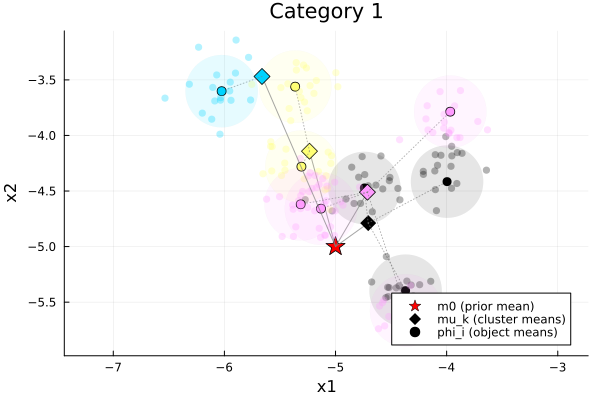

In [74]:
plot_category(category1, hyper1)

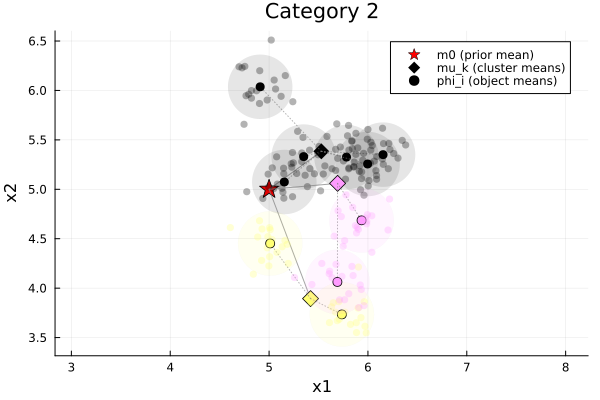

In [75]:
plot_category(category2, hyper2)